In [1]:
import os
import cv2
import pandas

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from imutils import build_montages
from tqdm import tqdm
from datetime import datetime
from google.colab import drive
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Activation, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Conv2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import ZeroPadding2D
from keras.initializers import RandomNormal
from tensorflow import keras


In [2]:
# mount google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# Environment

In [3]:
# Env

NUM_Z=100                         # Number of dimension manipulated into the lateted space 
BATCH_SIZE=128                    #
INIT_LR=2e-4                      # Learning rate
image_size = (32, 32)             #
noise = Input((NUM_Z))            # 
BATCH_SIZE_2 = BATCH_SIZE // 2
NUM_EPOCHS=351

conv_init = RandomNormal(mean=0.0, stddev=0.02)
gamma_init = RandomNormal(mean=1.0, stddev=0.02)

directory="/content/drive/MyDrive/Politecnico/5kLLD"
base_class="/5klogos"
directory_models="/content/drive/MyDrive/Politecnico/gen/"

# Utils

In [4]:
def generate_latent_points(latent_dim, n_samples):
	"""
	Function to generate random points in the latent space
	in this case, we are using a Gaussian (normal) distribution with 0 mean and 1.
	"""

	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [5]:
def preprocessing_function(x):
  """
  Function to preprocess the images so that they are in the range [-1, 1]
  the range of the real images should be the same of the fake images 
  """
  return (x - 127.5)/127.5

In [6]:
# Utility function to plot some figures
def plot_figures(x, n, figsize=None):
  if figsize:
      plt.figure(figsize=figsize)
  for i in range(n*n):
      plt.subplot(n,n,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      img=x[i,:,:,:]
      # Rescale for visualization purposes
      img = ((img*127.5) + 127.5).astype("uint8")
      plt.imshow(img)
    
  plt.show()

In [7]:
# Utility function to store some figures
def store_figures(x, n, directory, epoch):
  for i in range(n*n):
    img=x[i,:,:,:]
    # Rescale for visualization purposes
    img = ((img*127.5) + 127.5).astype("uint8")
    cv2.imwrite(os.path.join(directory, "logocGAN-" + str(epoch) + "-" + str(i) + ".png"), img)

In [8]:
# Utility function to plot loss figures
def plot_losses(history, lim):
  pandas.DataFrame(history).plot(figsize=(10,8))
  plt.grid(True)
  plt.gca().set_ylim(0,lim)
  plt.show()

# Model definition

In [9]:
def upResBlock(inp, n):
  tmp_x = inp
  x = Conv2DTranspose(filters=n,
                      kernel_size=(4, 4),
                      strides=(2, 2),
                      padding="same",
                      activation="relu")(inp)
  x = BatchNormalization(gamma_initializer = gamma_init, 
                         momentum=0.9, 
                         axis=1, 
                         epsilon=1.01e-5)(x)
  tmp_x = Conv2DTranspose(filters=n,
                          kernel_size=(1, 1),
                          strides=(2, 2),
                          padding="same")(tmp_x)
  x = x + tmp_x
  
  return x


In [10]:
def downResBlock(inp, n, ksize=4, alpha=0.2):
  # Use Leaky ReLU instead of Relu in the discriminator
  leaky = tf.keras.layers.LeakyReLU(alpha)

  tmp_x = inp
  x = Conv2D(filters=n,
             kernel_size=(ksize, ksize),
             strides=(2,2),
             padding="same",
             activation=leaky)(inp)
  tmp_x = Conv2D(filters=n,
                 kernel_size=(1, 1),
                 strides=(2, 2),
                 padding="same")(tmp_x)
  x = x + tmp_x

  return x


In [11]:
def build_generator(width, height, nz=200, n=512, channels=3):
  inp = Input(shape=(nz,))

  # FC - BN 
  dim1 = width // 16
  dim2 = height // 16
  
  x = Dense( dim1 * dim2 * n, activation="relu")(inp)
  x = BatchNormalization( gamma_initializer = gamma_init, 
                          momentum=0.9, 
                          axis=1, 
                          epsilon=1.01e-5)(x)

  x = Reshape((dim1, dim2,n))(x)

  # Adding upResBlock
  x = upResBlock(x, n//2)
  x = upResBlock(x, n//4)
  x = upResBlock(x, n//8)
  
  # Adding the final layer with tanh activation
  out = Conv2DTranspose(filters=channels,
                        kernel_size=(4,4),
                        strides=(2,2),
                        padding="same",
                        activation="tanh")(x)

  m = Model(inputs=inp, outputs=out)
  
  return m

In [12]:
def build_discriminator(width, height, channels, alpha=0.2, droprate=0.5):
    input_shape = (width, height, channels)
    n = 128

    inp = Input(shape=input_shape)

    # Adding downResBlock
    x = downResBlock(inp, n, ksize=4, alpha=alpha)
    x = downResBlock(x, n*2, ksize=4, alpha=alpha)
    x = downResBlock(x, n*4, ksize=2, alpha=alpha)
    
   
    x = Flatten()(x)

    # Use dropout to increase variability in the discriminator
    x = Dropout(droprate)(x)
    out = Dense(1, activation="sigmoid")(x)

    m = Model(inputs=inp, outputs=out)

    return m


# Compiling models

In [13]:
# Generator
gen = build_generator(image_size[0], image_size[1], nz=NUM_Z, n=512, channels=3)
gen.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 2048)         206848      ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048)        8192        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 reshape (Reshape)              (None, 2, 2, 512)    0           ['batch_normalization[0][0]']

In [14]:
## Discriminator
disc = build_discriminator(image_size[0], image_size[1], 3, droprate=0.5)
disc.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 128)  6272        ['input_3[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 128)  512         ['input_3[0][0]']                
                                                                                                  
 tf.__operators__.add_3 (TFOpLa  (None, 16, 16, 128)  0          ['conv2d[0][0]',                 
 mbda)                                                            'conv2d_1[0][0]']         

In [15]:
# Compile the discriminator
# beta_1 was could achieve best performances with Adam
discOpt = tf.keras.optimizers.Adam(lr=INIT_LR, beta_1=0.5)
disc.compile(discOpt, loss="binary_crossentropy", metrics=["accuracy"])
disc.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 128)  6272        ['input_3[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 128)  512         ['input_3[0][0]']                
                                                                                                  
 tf.__operators__.add_3 (TFOpLa  (None, 16, 16, 128)  0          ['conv2d[0][0]',                 
 mbda)                                                            'conv2d_1[0][0]']         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
# Connecting the two models

# Setting the discriminator to not trainable
disc.trainable = False

# Connecting the discriminator with the generator
discOutput=disc(gen(noise))
gan = Model(inputs=noise, outputs=discOutput)

ganOpt = tf.keras.optimizers.Adam(lr=INIT_LR, beta_1=0.5)
gan.compile(loss="binary_crossentropy", optimizer=ganOpt)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
gan.summary()
disc.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 model (Functional)          (None, 32, 32, 3)         3143667   
                                                                 
 model_1 (Functional)        (None, 1)                 1228929   
                                                                 
Total params: 4,372,596
Trainable params: 3,139,515
Non-trainable params: 1,233,081
_________________________________________________________________
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                       

In [18]:
# noise vector used during training in order to evaluate how the network is learning
benchmarkNoise = generate_latent_points(NUM_Z, BATCH_SIZE)

In [19]:
train_generator = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0.125,
    shear_range=0.1,
    zoom_range=0.25,
    fill_mode="nearest",
    horizontal_flip=True,  
    vertical_flip=True,  
    rescale=None,
    preprocessing_function=preprocessing_function
)


In [20]:
training_size = len(os.listdir(directory+base_class) )
print(f" Traning size: {training_size}")

 Traning size: 4999


In [21]:
train = train_generator.flow_from_directory(directory, target_size=image_size, batch_size=BATCH_SIZE, shuffle=True)

Found 4999 images belonging to 1 classes.


# Training for a given number of epochs



In [22]:
trueImages, _ = next(train)
trueImages.shape

(128, 32, 32, 3)

In [23]:
batchesPerEpoch = int(training_size / BATCH_SIZE)
print(f" Batches per epoch: {batchesPerEpoch}")

 Batches per epoch: 39


[i] (10:28:34) Epoch 0 [=]: Discriminator loss 0.5717720985412598 ( 0.7109375 ) - Generator loss 1.2045605182647705


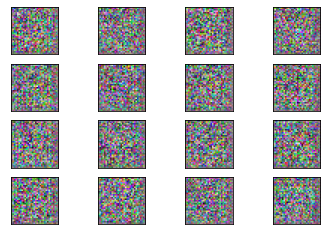

[i] (10:29:02) Epoch 1 [=]: Discriminator loss 0.21326568722724915 ( 0.9296875 ) - Generator loss 3.3506064414978027
[i] (10:29:15) Epoch 2 [=]: Discriminator loss 0.36285340785980225 ( 0.9296875 ) - Generator loss 2.444188117980957
[i] (10:29:29) Epoch 3 [=]: Discriminator loss 0.3588345944881439 ( 0.9296875 ) - Generator loss 2.1771697998046875
[i] (10:29:42) Epoch 4 [=]: Discriminator loss 0.358695924282074 ( 0.9296875 ) - Generator loss 2.205801486968994
[i] (10:29:56) Epoch 5 [=]: Discriminator loss 0.4155904948711395 ( 0.9375 ) - Generator loss 1.6606484651565552
[i] (10:30:09) Epoch 6 [=]: Discriminator loss 0.3865669369697571 ( 0.9453125 ) - Generator loss 1.4691218137741089
[i] (10:30:23) Epoch 7 [=]: Discriminator loss 0.388952374458313 ( 0.9375 ) - Generator loss 1.675276279449463
[i] (10:30:36) Epoch 8 [=]: Discriminator loss 0.3927081525325775 ( 0.9921875 ) - Generator loss 1.5728473663330078
[i] (10:30:50) Epoch 9 [=]: Discriminator loss 0.4876336455345154 ( 0.90625 ) - G

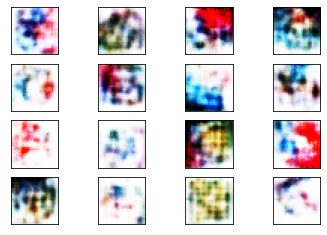

[i] (10:31:17) Epoch 11 [=]: Discriminator loss 0.5100406408309937 ( 0.890625 ) - Generator loss 1.2617758512496948
[i] (10:31:31) Epoch 12 [=]: Discriminator loss 0.48042237758636475 ( 0.8984375 ) - Generator loss 1.2736111879348755
[i] (10:31:44) Epoch 13 [=]: Discriminator loss 0.4895024001598358 ( 0.90625 ) - Generator loss 1.2920235395431519
[i] (10:31:58) Epoch 14 [=]: Discriminator loss 0.5151585936546326 ( 0.828125 ) - Generator loss 1.253340244293213
[i] (10:32:11) Epoch 15 [=]: Discriminator loss 0.46719813346862793 ( 0.9453125 ) - Generator loss 1.3585591316223145
[i] (10:32:25) Epoch 16 [=]: Discriminator loss 0.5358479619026184 ( 0.8203125 ) - Generator loss 1.232266902923584
[i] (10:32:38) Epoch 17 [=]: Discriminator loss 0.5602924823760986 ( 0.78125 ) - Generator loss 1.166048526763916
[i] (10:32:51) Epoch 18 [=]: Discriminator loss 0.5235504508018494 ( 0.84375 ) - Generator loss 1.1547610759735107
[i] (10:33:05) Epoch 19 [=]: Discriminator loss 0.46929046511650085 ( 0.9

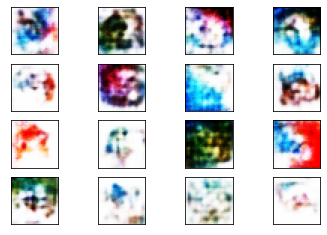

[i] (10:33:32) Epoch 21 [=]: Discriminator loss 0.5694839954376221 ( 0.78125 ) - Generator loss 1.0798838138580322
[i] (10:33:45) Epoch 22 [=]: Discriminator loss 0.5094148516654968 ( 0.8828125 ) - Generator loss 1.1452962160110474
[i] (10:33:59) Epoch 23 [=]: Discriminator loss 0.4729980230331421 ( 0.9140625 ) - Generator loss 1.2405941486358643
[i] (10:34:12) Epoch 24 [=]: Discriminator loss 0.504216194152832 ( 0.8515625 ) - Generator loss 1.2473671436309814
[i] (10:34:25) Epoch 25 [=]: Discriminator loss 0.505339503288269 ( 0.8515625 ) - Generator loss 1.1398614645004272
[i] (10:34:39) Epoch 26 [=]: Discriminator loss 0.5237252712249756 ( 0.84375 ) - Generator loss 1.2479201555252075
[i] (10:34:52) Epoch 27 [=]: Discriminator loss 0.5095955729484558 ( 0.8828125 ) - Generator loss 1.2286536693572998
[i] (10:35:05) Epoch 28 [=]: Discriminator loss 0.4772123694419861 ( 0.8828125 ) - Generator loss 1.2659815549850464
[i] (10:35:19) Epoch 29 [=]: Discriminator loss 0.5204166173934937 ( 0

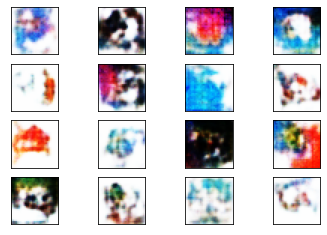

[i] (10:35:46) Epoch 31 [=]: Discriminator loss 0.5107156038284302 ( 0.8828125 ) - Generator loss 1.186507225036621
[i] (10:36:00) Epoch 32 [=]: Discriminator loss 0.5159133672714233 ( 0.8515625 ) - Generator loss 1.2031522989273071
[i] (10:36:13) Epoch 33 [=]: Discriminator loss 0.4921036958694458 ( 0.8984375 ) - Generator loss 1.1892415285110474
[i] (10:36:27) Epoch 34 [=]: Discriminator loss 0.5005908608436584 ( 0.8984375 ) - Generator loss 1.2793463468551636
[i] (10:36:40) Epoch 35 [=]: Discriminator loss 0.5090417265892029 ( 0.859375 ) - Generator loss 1.1895265579223633
[i] (10:36:53) Epoch 36 [=]: Discriminator loss 0.45995569229125977 ( 0.8984375 ) - Generator loss 1.2468262910842896
[i] (10:37:07) Epoch 37 [=]: Discriminator loss 0.49934297800064087 ( 0.8515625 ) - Generator loss 1.0807573795318604
[i] (10:37:20) Epoch 38 [=]: Discriminator loss 0.5428386926651001 ( 0.8125 ) - Generator loss 1.1222822666168213
[i] (10:37:33) Epoch 39 [=]: Discriminator loss 0.46121448278427124

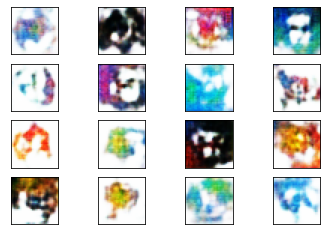

[i] (10:38:01) Epoch 41 [=]: Discriminator loss 0.45392394065856934 ( 0.953125 ) - Generator loss 1.291129231452942
[i] (10:38:14) Epoch 42 [=]: Discriminator loss 0.4505065381526947 ( 0.9609375 ) - Generator loss 1.3406035900115967
[i] (10:38:27) Epoch 43 [=]: Discriminator loss 0.4627428650856018 ( 0.8828125 ) - Generator loss 1.2668170928955078
[i] (10:38:41) Epoch 44 [=]: Discriminator loss 0.48137858510017395 ( 0.8828125 ) - Generator loss 1.2499136924743652
[i] (10:38:55) Epoch 45 [=]: Discriminator loss 0.473417192697525 ( 0.8984375 ) - Generator loss 1.212991714477539
[i] (10:39:08) Epoch 46 [=]: Discriminator loss 0.5472222566604614 ( 0.75 ) - Generator loss 1.2036364078521729
[i] (10:39:21) Epoch 47 [=]: Discriminator loss 0.47301632165908813 ( 0.8984375 ) - Generator loss 1.2703354358673096
[i] (10:39:35) Epoch 48 [=]: Discriminator loss 0.49108919501304626 ( 0.828125 ) - Generator loss 1.3230595588684082
[i] (10:39:48) Epoch 49 [=]: Discriminator loss 0.508455216884613 ( 0.

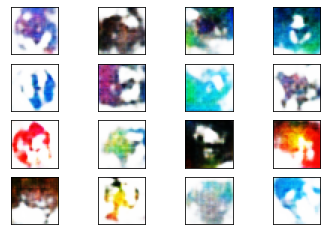

[i] (10:40:15) Epoch 51 [=]: Discriminator loss 0.47059500217437744 ( 0.953125 ) - Generator loss 1.313262701034546
[i] (10:40:28) Epoch 52 [=]: Discriminator loss 0.4548739194869995 ( 0.8515625 ) - Generator loss 1.380136489868164
[i] (10:40:42) Epoch 53 [=]: Discriminator loss 0.46083948016166687 ( 0.921875 ) - Generator loss 1.2757022380828857
[i] (10:40:55) Epoch 54 [=]: Discriminator loss 0.45182669162750244 ( 0.8984375 ) - Generator loss 1.3738362789154053
[i] (10:41:08) Epoch 55 [=]: Discriminator loss 0.5271028280258179 ( 0.796875 ) - Generator loss 1.3352491855621338
[i] (10:41:22) Epoch 56 [=]: Discriminator loss 0.4762287735939026 ( 0.890625 ) - Generator loss 1.2528886795043945
[i] (10:41:35) Epoch 57 [=]: Discriminator loss 0.5224127769470215 ( 0.828125 ) - Generator loss 1.2318497896194458
[i] (10:41:49) Epoch 58 [=]: Discriminator loss 0.5910845994949341 ( 0.734375 ) - Generator loss 1.2869051694869995
[i] (10:42:02) Epoch 59 [=]: Discriminator loss 0.457965612411499 ( 0

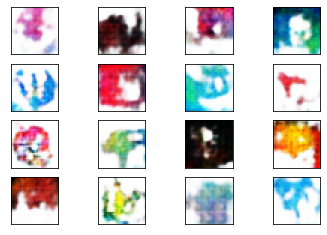

[i] (10:42:30) Epoch 61 [=]: Discriminator loss 0.5088473558425903 ( 0.8671875 ) - Generator loss 1.2752110958099365
[i] (10:42:43) Epoch 62 [=]: Discriminator loss 0.5208466053009033 ( 0.8828125 ) - Generator loss 1.1714695692062378
[i] (10:42:57) Epoch 63 [=]: Discriminator loss 0.5220138430595398 ( 0.84375 ) - Generator loss 1.1421446800231934
[i] (10:43:10) Epoch 64 [=]: Discriminator loss 0.4629737138748169 ( 0.859375 ) - Generator loss 1.3486113548278809
[i] (10:43:23) Epoch 65 [=]: Discriminator loss 0.45573705434799194 ( 0.890625 ) - Generator loss 1.2427681684494019
[i] (10:43:36) Epoch 66 [=]: Discriminator loss 0.4999864101409912 ( 0.8203125 ) - Generator loss 1.24422287940979
[i] (10:43:50) Epoch 67 [=]: Discriminator loss 0.4870038330554962 ( 0.8515625 ) - Generator loss 1.2636237144470215
[i] (10:44:03) Epoch 68 [=]: Discriminator loss 0.5039235353469849 ( 0.8671875 ) - Generator loss 1.1802763938903809
[i] (10:44:16) Epoch 69 [=]: Discriminator loss 0.47576218843460083 (

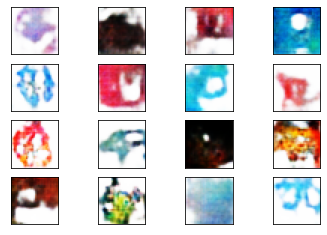

[i] (10:44:44) Epoch 71 [=]: Discriminator loss 0.5374211668968201 ( 0.8359375 ) - Generator loss 1.2089934349060059
[i] (10:44:57) Epoch 72 [=]: Discriminator loss 0.49639394879341125 ( 0.84375 ) - Generator loss 1.1934304237365723
[i] (10:45:11) Epoch 73 [=]: Discriminator loss 0.511792004108429 ( 0.8515625 ) - Generator loss 1.1256722211837769
[i] (10:45:24) Epoch 74 [=]: Discriminator loss 0.5161275267601013 ( 0.859375 ) - Generator loss 1.1394975185394287
[i] (10:45:37) Epoch 75 [=]: Discriminator loss 0.4990348219871521 ( 0.8984375 ) - Generator loss 1.1727546453475952
[i] (10:45:50) Epoch 76 [=]: Discriminator loss 0.5099549293518066 ( 0.859375 ) - Generator loss 1.1027867794036865
[i] (10:46:04) Epoch 77 [=]: Discriminator loss 0.5334796905517578 ( 0.859375 ) - Generator loss 1.1418696641921997
[i] (10:46:17) Epoch 78 [=]: Discriminator loss 0.4721056818962097 ( 0.8515625 ) - Generator loss 1.2697941064834595
[i] (10:46:31) Epoch 79 [=]: Discriminator loss 0.6191890239715576 ( 

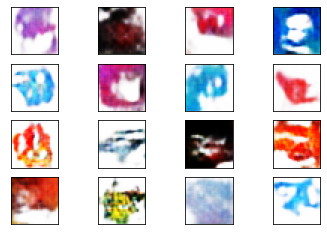

[i] (10:46:58) Epoch 81 [=]: Discriminator loss 0.510381281375885 ( 0.8359375 ) - Generator loss 1.1400593519210815
[i] (10:47:13) Epoch 82 [=]: Discriminator loss 0.5792204141616821 ( 0.796875 ) - Generator loss 1.0890612602233887
[i] (10:47:26) Epoch 83 [=]: Discriminator loss 0.5267223119735718 ( 0.828125 ) - Generator loss 1.1459537744522095
[i] (10:47:39) Epoch 84 [=]: Discriminator loss 0.4765157401561737 ( 0.9140625 ) - Generator loss 1.1520613431930542
[i] (10:47:53) Epoch 85 [=]: Discriminator loss 0.5375339984893799 ( 0.8125 ) - Generator loss 1.1099705696105957
[i] (10:48:06) Epoch 86 [=]: Discriminator loss 0.5131904482841492 ( 0.890625 ) - Generator loss 1.0646820068359375
[i] (10:48:19) Epoch 87 [=]: Discriminator loss 0.5470049381256104 ( 0.7890625 ) - Generator loss 1.0924609899520874
[i] (10:48:32) Epoch 88 [=]: Discriminator loss 0.5066009163856506 ( 0.9140625 ) - Generator loss 1.0896003246307373
[i] (10:48:45) Epoch 89 [=]: Discriminator loss 0.5460900664329529 ( 0.

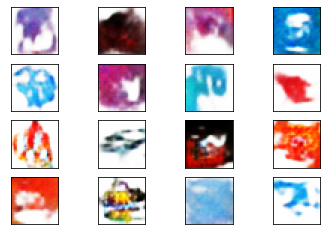

[i] (10:49:13) Epoch 91 [=]: Discriminator loss 0.543161153793335 ( 0.8203125 ) - Generator loss 1.0835739374160767
[i] (10:49:26) Epoch 92 [=]: Discriminator loss 0.5581592321395874 ( 0.78125 ) - Generator loss 1.089590311050415
[i] (10:49:39) Epoch 93 [=]: Discriminator loss 0.5640273094177246 ( 0.7734375 ) - Generator loss 1.0658221244812012
[i] (10:49:53) Epoch 94 [=]: Discriminator loss 0.5592480897903442 ( 0.8203125 ) - Generator loss 1.0126714706420898
[i] (10:50:06) Epoch 95 [=]: Discriminator loss 0.5526595711708069 ( 0.828125 ) - Generator loss 1.0286614894866943
[i] (10:50:19) Epoch 96 [=]: Discriminator loss 0.5347186326980591 ( 0.8515625 ) - Generator loss 1.057713508605957
[i] (10:50:32) Epoch 97 [=]: Discriminator loss 0.5219070911407471 ( 0.890625 ) - Generator loss 1.065845012664795
[i] (10:50:45) Epoch 98 [=]: Discriminator loss 0.5398557782173157 ( 0.859375 ) - Generator loss 1.0158863067626953
[i] (10:50:59) Epoch 99 [=]: Discriminator loss 0.5024286508560181 ( 0.90

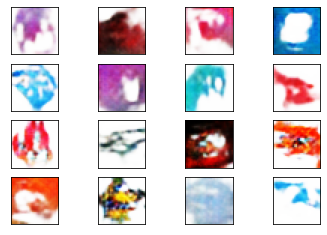

[i] (10:51:26) Epoch 101 [=]: Discriminator loss 0.5602999329566956 ( 0.796875 ) - Generator loss 1.1082903146743774
[i] (10:51:39) Epoch 102 [=]: Discriminator loss 0.5389635562896729 ( 0.84375 ) - Generator loss 1.0717051029205322
[i] (10:51:53) Epoch 103 [=]: Discriminator loss 0.5285207033157349 ( 0.875 ) - Generator loss 1.0628011226654053
[i] (10:52:06) Epoch 104 [=]: Discriminator loss 0.5877368450164795 ( 0.7421875 ) - Generator loss 1.056047797203064
[i] (10:52:19) Epoch 105 [=]: Discriminator loss 0.5247746706008911 ( 0.8515625 ) - Generator loss 1.0233172178268433
[i] (10:52:33) Epoch 106 [=]: Discriminator loss 0.5151657462120056 ( 0.9140625 ) - Generator loss 1.0762197971343994
[i] (10:52:46) Epoch 107 [=]: Discriminator loss 0.5662967562675476 ( 0.78125 ) - Generator loss 1.0965087413787842
[i] (10:52:59) Epoch 108 [=]: Discriminator loss 0.5197834968566895 ( 0.8359375 ) - Generator loss 1.054709792137146
[i] (10:53:12) Epoch 109 [=]: Discriminator loss 0.5310628414154053

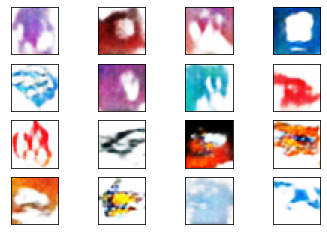

[i] (10:53:40) Epoch 111 [=]: Discriminator loss 0.500937819480896 ( 0.90625 ) - Generator loss 1.1135746240615845
[i] (10:53:53) Epoch 112 [=]: Discriminator loss 0.5214652419090271 ( 0.828125 ) - Generator loss 1.1529000997543335
[i] (10:54:07) Epoch 113 [=]: Discriminator loss 0.5502743721008301 ( 0.7734375 ) - Generator loss 1.0162214040756226
[i] (10:54:20) Epoch 114 [=]: Discriminator loss 0.5374040603637695 ( 0.8203125 ) - Generator loss 1.049844741821289
[i] (10:54:33) Epoch 115 [=]: Discriminator loss 0.5626361966133118 ( 0.796875 ) - Generator loss 1.0476739406585693
[i] (10:54:46) Epoch 116 [=]: Discriminator loss 0.5109072923660278 ( 0.890625 ) - Generator loss 1.0723967552185059
[i] (10:54:59) Epoch 117 [=]: Discriminator loss 0.5430575609207153 ( 0.875 ) - Generator loss 1.0265073776245117
[i] (10:55:12) Epoch 118 [=]: Discriminator loss 0.5733457803726196 ( 0.7578125 ) - Generator loss 1.1041721105575562
[i] (10:55:26) Epoch 119 [=]: Discriminator loss 0.5278223156929016

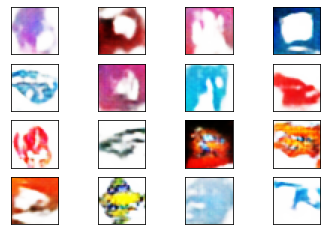

[i] (10:55:53) Epoch 121 [=]: Discriminator loss 0.5069812536239624 ( 0.890625 ) - Generator loss 1.0799859762191772
[i] (10:56:06) Epoch 122 [=]: Discriminator loss 0.48246076703071594 ( 0.890625 ) - Generator loss 1.1474645137786865
[i] (10:56:20) Epoch 123 [=]: Discriminator loss 0.5205055475234985 ( 0.84375 ) - Generator loss 1.0868654251098633
[i] (10:56:33) Epoch 124 [=]: Discriminator loss 0.5393385291099548 ( 0.8203125 ) - Generator loss 1.1210498809814453
[i] (10:56:47) Epoch 125 [=]: Discriminator loss 0.573651909828186 ( 0.78125 ) - Generator loss 1.069046139717102
[i] (10:57:00) Epoch 126 [=]: Discriminator loss 0.5430236458778381 ( 0.8203125 ) - Generator loss 1.0675145387649536
[i] (10:57:14) Epoch 127 [=]: Discriminator loss 0.5384905934333801 ( 0.7890625 ) - Generator loss 1.0569078922271729
[i] (10:57:27) Epoch 128 [=]: Discriminator loss 0.48950985074043274 ( 0.90625 ) - Generator loss 1.1064348220825195
[i] (10:57:40) Epoch 129 [=]: Discriminator loss 0.5152975916862

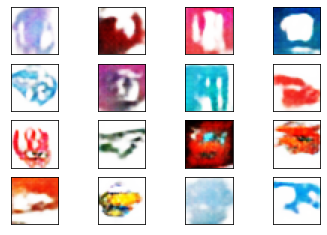

[i] (10:58:07) Epoch 131 [=]: Discriminator loss 0.5131328701972961 ( 0.90625 ) - Generator loss 1.099229335784912
[i] (10:58:21) Epoch 132 [=]: Discriminator loss 0.5086925625801086 ( 0.859375 ) - Generator loss 1.1232330799102783
[i] (10:58:34) Epoch 133 [=]: Discriminator loss 0.5268943309783936 ( 0.84375 ) - Generator loss 1.1789886951446533
[i] (10:58:47) Epoch 134 [=]: Discriminator loss 0.5249070525169373 ( 0.8359375 ) - Generator loss 1.1641939878463745
[i] (10:59:01) Epoch 135 [=]: Discriminator loss 0.5653518438339233 ( 0.7421875 ) - Generator loss 1.126428484916687
[i] (10:59:14) Epoch 136 [=]: Discriminator loss 0.498867928981781 ( 0.8671875 ) - Generator loss 1.134960651397705
[i] (10:59:27) Epoch 137 [=]: Discriminator loss 0.5170225501060486 ( 0.8671875 ) - Generator loss 1.1265430450439453
[i] (10:59:40) Epoch 138 [=]: Discriminator loss 0.5381746292114258 ( 0.8125 ) - Generator loss 1.1517658233642578
[i] (10:59:54) Epoch 139 [=]: Discriminator loss 0.49549221992492676

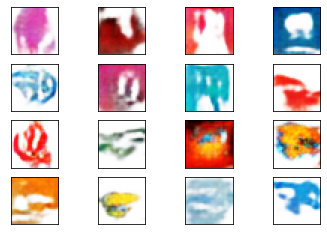

[i] (11:00:21) Epoch 141 [=]: Discriminator loss 0.5379889607429504 ( 0.8203125 ) - Generator loss 1.0886400938034058
[i] (11:00:34) Epoch 142 [=]: Discriminator loss 0.5106825828552246 ( 0.890625 ) - Generator loss 1.1557382345199585
[i] (11:00:48) Epoch 143 [=]: Discriminator loss 0.4906069040298462 ( 0.8515625 ) - Generator loss 1.1579935550689697
[i] (11:01:01) Epoch 144 [=]: Discriminator loss 0.5329988598823547 ( 0.78125 ) - Generator loss 1.0777864456176758
[i] (11:01:14) Epoch 145 [=]: Discriminator loss 0.5436652898788452 ( 0.8203125 ) - Generator loss 1.0963692665100098
[i] (11:01:27) Epoch 146 [=]: Discriminator loss 0.5293942093849182 ( 0.8359375 ) - Generator loss 1.0749571323394775
[i] (11:01:40) Epoch 147 [=]: Discriminator loss 0.5067123174667358 ( 0.8515625 ) - Generator loss 1.126249074935913
[i] (11:01:54) Epoch 148 [=]: Discriminator loss 0.5162233710289001 ( 0.828125 ) - Generator loss 1.1355481147766113
[i] (11:02:07) Epoch 149 [=]: Discriminator loss 0.5234079360

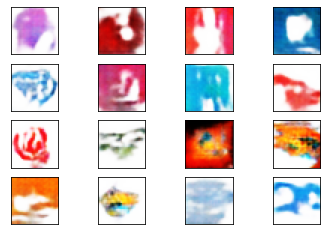

[i] (11:02:35) Epoch 151 [=]: Discriminator loss 0.4932185411453247 ( 0.8671875 ) - Generator loss 1.1984931230545044
[i] (11:02:48) Epoch 152 [=]: Discriminator loss 0.5184923410415649 ( 0.8671875 ) - Generator loss 1.121169090270996
[i] (11:03:01) Epoch 153 [=]: Discriminator loss 0.5030322074890137 ( 0.8828125 ) - Generator loss 1.1074355840682983
[i] (11:03:15) Epoch 154 [=]: Discriminator loss 0.5035321116447449 ( 0.8203125 ) - Generator loss 1.1436359882354736
[i] (11:03:28) Epoch 155 [=]: Discriminator loss 0.4779118597507477 ( 0.890625 ) - Generator loss 1.1823517084121704
[i] (11:03:41) Epoch 156 [=]: Discriminator loss 0.5037418007850647 ( 0.859375 ) - Generator loss 1.1466968059539795
[i] (11:03:55) Epoch 157 [=]: Discriminator loss 0.49481236934661865 ( 0.8515625 ) - Generator loss 1.1208882331848145
[i] (11:04:08) Epoch 158 [=]: Discriminator loss 0.5870985984802246 ( 0.734375 ) - Generator loss 1.0483510494232178
[i] (11:04:22) Epoch 159 [=]: Discriminator loss 0.50944387

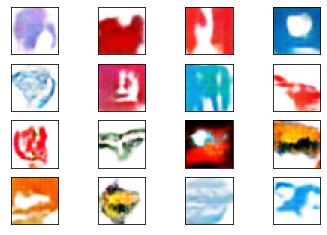

[i] (11:04:49) Epoch 161 [=]: Discriminator loss 0.5477614402770996 ( 0.8203125 ) - Generator loss 1.1438720226287842
[i] (11:05:03) Epoch 162 [=]: Discriminator loss 0.4736981987953186 ( 0.921875 ) - Generator loss 1.0761774778366089
[i] (11:05:16) Epoch 163 [=]: Discriminator loss 0.5441792011260986 ( 0.8515625 ) - Generator loss 1.1192549467086792
[i] (11:05:30) Epoch 164 [=]: Discriminator loss 0.5215626358985901 ( 0.8984375 ) - Generator loss 1.115197777748108
[i] (11:05:43) Epoch 165 [=]: Discriminator loss 0.5198873281478882 ( 0.875 ) - Generator loss 1.0566668510437012
[i] (11:05:56) Epoch 166 [=]: Discriminator loss 0.4855036735534668 ( 0.8671875 ) - Generator loss 1.1064509153366089
[i] (11:06:10) Epoch 167 [=]: Discriminator loss 0.5382770299911499 ( 0.7890625 ) - Generator loss 1.18339204788208
[i] (11:06:23) Epoch 168 [=]: Discriminator loss 0.4932014048099518 ( 0.921875 ) - Generator loss 1.102001667022705
[i] (11:06:36) Epoch 169 [=]: Discriminator loss 0.557155013084411

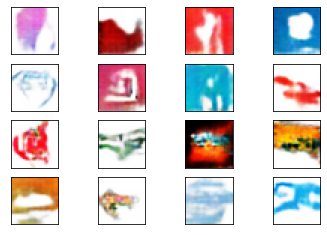

[i] (11:07:04) Epoch 171 [=]: Discriminator loss 0.4936012923717499 ( 0.921875 ) - Generator loss 1.1144733428955078
[i] (11:07:18) Epoch 172 [=]: Discriminator loss 0.5381501317024231 ( 0.8359375 ) - Generator loss 1.0910215377807617
[i] (11:07:32) Epoch 173 [=]: Discriminator loss 0.49676600098609924 ( 0.890625 ) - Generator loss 1.1114792823791504
[i] (11:07:45) Epoch 174 [=]: Discriminator loss 0.5656144618988037 ( 0.75 ) - Generator loss 1.1259219646453857
[i] (11:07:58) Epoch 175 [=]: Discriminator loss 0.5166550278663635 ( 0.8515625 ) - Generator loss 1.0842243432998657
[i] (11:08:12) Epoch 176 [=]: Discriminator loss 0.5193434953689575 ( 0.84375 ) - Generator loss 1.1567283868789673
[i] (11:08:25) Epoch 177 [=]: Discriminator loss 0.49204179644584656 ( 0.9140625 ) - Generator loss 1.1290333271026611
[i] (11:08:38) Epoch 178 [=]: Discriminator loss 0.5568956136703491 ( 0.796875 ) - Generator loss 1.0431394577026367
[i] (11:08:52) Epoch 179 [=]: Discriminator loss 0.5122957229614

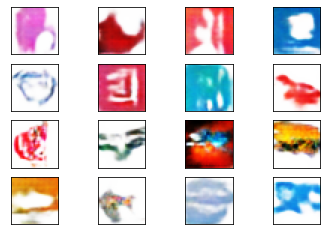

[i] (11:09:19) Epoch 181 [=]: Discriminator loss 0.5468454360961914 ( 0.8515625 ) - Generator loss 1.054474115371704
[i] (11:09:33) Epoch 182 [=]: Discriminator loss 0.5532496571540833 ( 0.8359375 ) - Generator loss 1.0551091432571411
[i] (11:09:46) Epoch 183 [=]: Discriminator loss 0.4942130446434021 ( 0.8828125 ) - Generator loss 1.0933353900909424
[i] (11:09:59) Epoch 184 [=]: Discriminator loss 0.6355393528938293 ( 0.71875 ) - Generator loss 1.1262733936309814
[i] (11:10:13) Epoch 185 [=]: Discriminator loss 0.5208880305290222 ( 0.859375 ) - Generator loss 1.0778605937957764
[i] (11:10:26) Epoch 186 [=]: Discriminator loss 0.5314109325408936 ( 0.8671875 ) - Generator loss 1.0966240167617798
[i] (11:10:39) Epoch 187 [=]: Discriminator loss 0.5329610109329224 ( 0.8671875 ) - Generator loss 1.1264386177062988
[i] (11:10:53) Epoch 188 [=]: Discriminator loss 0.5067145228385925 ( 0.8515625 ) - Generator loss 1.1141974925994873
[i] (11:11:06) Epoch 189 [=]: Discriminator loss 0.473251789

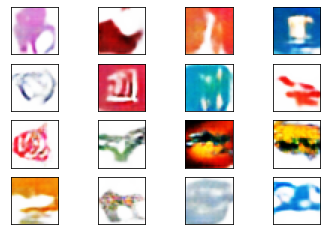

[i] (11:11:33) Epoch 191 [=]: Discriminator loss 0.5434771180152893 ( 0.8125 ) - Generator loss 1.1147135496139526
[i] (11:11:47) Epoch 192 [=]: Discriminator loss 0.5554563999176025 ( 0.796875 ) - Generator loss 1.1259300708770752
[i] (11:12:00) Epoch 193 [=]: Discriminator loss 0.5054584741592407 ( 0.90625 ) - Generator loss 1.1819287538528442
[i] (11:12:13) Epoch 194 [=]: Discriminator loss 0.5155263543128967 ( 0.859375 ) - Generator loss 1.0660929679870605
[i] (11:12:27) Epoch 195 [=]: Discriminator loss 0.5015062093734741 ( 0.8671875 ) - Generator loss 1.1219671964645386
[i] (11:12:40) Epoch 196 [=]: Discriminator loss 0.5222482085227966 ( 0.8515625 ) - Generator loss 1.1499109268188477
[i] (11:12:54) Epoch 197 [=]: Discriminator loss 0.583126962184906 ( 0.7578125 ) - Generator loss 1.0443121194839478
[i] (11:13:07) Epoch 198 [=]: Discriminator loss 0.5389684438705444 ( 0.8125 ) - Generator loss 1.0999963283538818
[i] (11:13:21) Epoch 199 [=]: Discriminator loss 0.5625373125076294

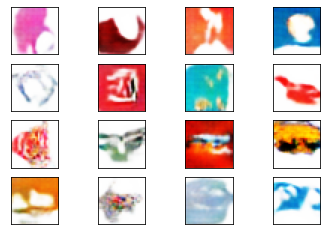

[i] (11:13:48) Epoch 201 [=]: Discriminator loss 0.4502532482147217 ( 0.921875 ) - Generator loss 1.1954237222671509
[i] (11:14:02) Epoch 202 [=]: Discriminator loss 0.544911801815033 ( 0.8046875 ) - Generator loss 1.0777792930603027
[i] (11:14:15) Epoch 203 [=]: Discriminator loss 0.5210673213005066 ( 0.84375 ) - Generator loss 1.1022930145263672
[i] (11:14:28) Epoch 204 [=]: Discriminator loss 0.46490854024887085 ( 0.8984375 ) - Generator loss 1.1906778812408447
[i] (11:14:42) Epoch 205 [=]: Discriminator loss 0.5208700895309448 ( 0.8828125 ) - Generator loss 1.074591875076294
[i] (11:14:55) Epoch 206 [=]: Discriminator loss 0.5189388394355774 ( 0.84375 ) - Generator loss 1.1348403692245483
[i] (11:15:08) Epoch 207 [=]: Discriminator loss 0.509796679019928 ( 0.8125 ) - Generator loss 1.0938615798950195
[i] (11:15:21) Epoch 208 [=]: Discriminator loss 0.5810114145278931 ( 0.7421875 ) - Generator loss 1.1505115032196045
[i] (11:15:35) Epoch 209 [=]: Discriminator loss 0.585710823535919

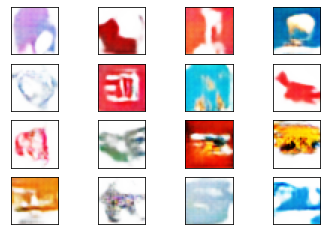

[i] (11:16:02) Epoch 211 [=]: Discriminator loss 0.5153259038925171 ( 0.859375 ) - Generator loss 1.134179711341858
[i] (11:16:15) Epoch 212 [=]: Discriminator loss 0.4962103068828583 ( 0.90625 ) - Generator loss 1.1079027652740479
[i] (11:16:28) Epoch 213 [=]: Discriminator loss 0.5168341398239136 ( 0.8671875 ) - Generator loss 1.0653512477874756
[i] (11:16:42) Epoch 214 [=]: Discriminator loss 0.5370715856552124 ( 0.8046875 ) - Generator loss 1.1479389667510986
[i] (11:16:55) Epoch 215 [=]: Discriminator loss 0.528259813785553 ( 0.8828125 ) - Generator loss 1.1003223657608032
[i] (11:17:08) Epoch 216 [=]: Discriminator loss 0.47595688700675964 ( 0.90625 ) - Generator loss 1.1285897493362427
[i] (11:17:22) Epoch 217 [=]: Discriminator loss 0.5054175853729248 ( 0.84375 ) - Generator loss 1.124455451965332
[i] (11:17:35) Epoch 218 [=]: Discriminator loss 0.5002205967903137 ( 0.8828125 ) - Generator loss 1.1262428760528564
[i] (11:17:48) Epoch 219 [=]: Discriminator loss 0.55045533180236

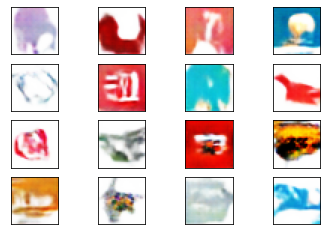

[i] (11:18:16) Epoch 221 [=]: Discriminator loss 0.5129168033599854 ( 0.859375 ) - Generator loss 1.0866315364837646
[i] (11:18:29) Epoch 222 [=]: Discriminator loss 0.6459370851516724 ( 0.6171875 ) - Generator loss 1.0173940658569336
[i] (11:18:43) Epoch 223 [=]: Discriminator loss 0.49330613017082214 ( 0.8671875 ) - Generator loss 1.1352870464324951
[i] (11:18:56) Epoch 224 [=]: Discriminator loss 0.5286816358566284 ( 0.828125 ) - Generator loss 1.118884801864624
[i] (11:19:09) Epoch 225 [=]: Discriminator loss 0.5020087957382202 ( 0.8828125 ) - Generator loss 1.1614302396774292
[i] (11:19:22) Epoch 226 [=]: Discriminator loss 0.4808240532875061 ( 0.8515625 ) - Generator loss 1.0969533920288086
[i] (11:19:35) Epoch 227 [=]: Discriminator loss 0.5267516374588013 ( 0.8671875 ) - Generator loss 1.0332833528518677
[i] (11:19:49) Epoch 228 [=]: Discriminator loss 0.48064157366752625 ( 0.9140625 ) - Generator loss 1.1282362937927246
[i] (11:20:02) Epoch 229 [=]: Discriminator loss 0.500236

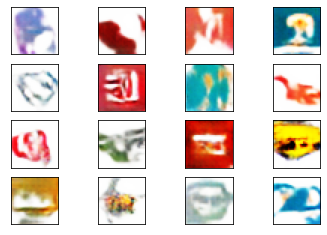

[i] (11:20:29) Epoch 231 [=]: Discriminator loss 0.4957882761955261 ( 0.890625 ) - Generator loss 1.1028335094451904
[i] (11:20:42) Epoch 232 [=]: Discriminator loss 0.48931071162223816 ( 0.875 ) - Generator loss 1.1138339042663574
[i] (11:20:55) Epoch 233 [=]: Discriminator loss 0.48006343841552734 ( 0.875 ) - Generator loss 1.144901990890503
[i] (11:21:09) Epoch 234 [=]: Discriminator loss 0.505243718624115 ( 0.8125 ) - Generator loss 1.1551036834716797
[i] (11:21:22) Epoch 235 [=]: Discriminator loss 0.4805861711502075 ( 0.890625 ) - Generator loss 1.1064820289611816
[i] (11:21:35) Epoch 236 [=]: Discriminator loss 0.506494402885437 ( 0.84375 ) - Generator loss 1.1684778928756714
[i] (11:21:48) Epoch 237 [=]: Discriminator loss 0.5045413374900818 ( 0.8828125 ) - Generator loss 1.0503253936767578
[i] (11:22:01) Epoch 238 [=]: Discriminator loss 0.512846827507019 ( 0.8203125 ) - Generator loss 1.3216655254364014
[i] (11:22:14) Epoch 239 [=]: Discriminator loss 0.6069575548171997 ( 0.7

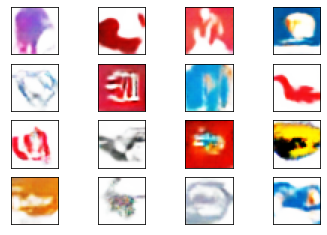

[i] (11:22:42) Epoch 241 [=]: Discriminator loss 0.46831899881362915 ( 0.875 ) - Generator loss 1.2069545984268188
[i] (11:22:56) Epoch 242 [=]: Discriminator loss 0.5111126899719238 ( 0.859375 ) - Generator loss 1.1395578384399414
[i] (11:23:09) Epoch 243 [=]: Discriminator loss 0.4692263603210449 ( 0.921875 ) - Generator loss 1.1348226070404053
[i] (11:23:22) Epoch 244 [=]: Discriminator loss 0.6248822212219238 ( 0.6640625 ) - Generator loss 1.1797008514404297
[i] (11:23:35) Epoch 245 [=]: Discriminator loss 0.44875237345695496 ( 0.953125 ) - Generator loss 1.198038935661316
[i] (11:23:48) Epoch 246 [=]: Discriminator loss 0.5111250877380371 ( 0.8359375 ) - Generator loss 1.1467300653457642
[i] (11:24:02) Epoch 247 [=]: Discriminator loss 0.5048226714134216 ( 0.8671875 ) - Generator loss 1.1143847703933716
[i] (11:24:15) Epoch 248 [=]: Discriminator loss 0.44273513555526733 ( 0.9140625 ) - Generator loss 1.1731394529342651
[i] (11:24:28) Epoch 249 [=]: Discriminator loss 0.4987394809

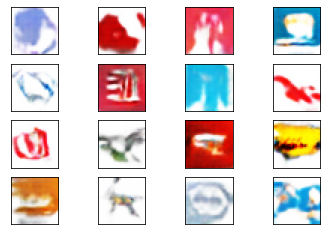

[i] (11:24:55) Epoch 251 [=]: Discriminator loss 0.5006641149520874 ( 0.8671875 ) - Generator loss 1.1512506008148193
[i] (11:25:09) Epoch 252 [=]: Discriminator loss 0.4836229383945465 ( 0.890625 ) - Generator loss 1.129084825515747
[i] (11:25:22) Epoch 253 [=]: Discriminator loss 0.4563886523246765 ( 0.921875 ) - Generator loss 1.1274968385696411
[i] (11:25:35) Epoch 254 [=]: Discriminator loss 0.5211371779441833 ( 0.8203125 ) - Generator loss 1.1155619621276855
[i] (11:25:48) Epoch 255 [=]: Discriminator loss 0.4940323233604431 ( 0.859375 ) - Generator loss 1.1909769773483276
[i] (11:26:01) Epoch 256 [=]: Discriminator loss 0.5009150505065918 ( 0.8671875 ) - Generator loss 1.2330546379089355
[i] (11:26:15) Epoch 257 [=]: Discriminator loss 0.48981326818466187 ( 0.875 ) - Generator loss 1.191091537475586
[i] (11:26:28) Epoch 258 [=]: Discriminator loss 0.4690078794956207 ( 0.9296875 ) - Generator loss 1.1930989027023315
[i] (11:26:41) Epoch 259 [=]: Discriminator loss 0.5016475915908

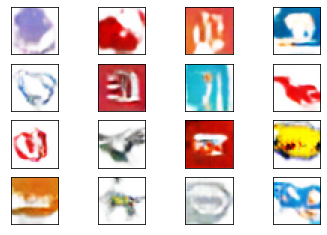

[i] (11:27:09) Epoch 261 [=]: Discriminator loss 0.4843844771385193 ( 0.859375 ) - Generator loss 1.135330319404602
[i] (11:27:22) Epoch 262 [=]: Discriminator loss 0.49196359515190125 ( 0.8828125 ) - Generator loss 1.2107023000717163
[i] (11:27:36) Epoch 263 [=]: Discriminator loss 0.5090084075927734 ( 0.859375 ) - Generator loss 1.2042603492736816
[i] (11:27:49) Epoch 264 [=]: Discriminator loss 0.4459824562072754 ( 0.8828125 ) - Generator loss 1.201994776725769
[i] (11:28:02) Epoch 265 [=]: Discriminator loss 0.446572870016098 ( 0.8828125 ) - Generator loss 1.173949122428894
[i] (11:28:16) Epoch 266 [=]: Discriminator loss 0.4524311423301697 ( 0.953125 ) - Generator loss 1.1691683530807495
[i] (11:28:29) Epoch 267 [=]: Discriminator loss 0.46410036087036133 ( 0.8984375 ) - Generator loss 1.155773639678955
[i] (11:28:42) Epoch 268 [=]: Discriminator loss 0.458852618932724 ( 0.875 ) - Generator loss 1.1881089210510254
[i] (11:28:56) Epoch 269 [=]: Discriminator loss 0.4978378415107727

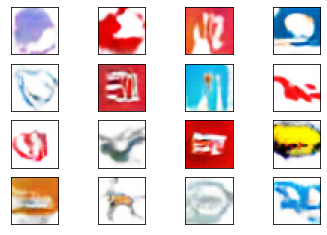

[i] (11:29:23) Epoch 271 [=]: Discriminator loss 0.5026164054870605 ( 0.8125 ) - Generator loss 1.2272961139678955
[i] (11:29:36) Epoch 272 [=]: Discriminator loss 0.46370792388916016 ( 0.90625 ) - Generator loss 1.219009518623352
[i] (11:29:49) Epoch 273 [=]: Discriminator loss 0.5232806205749512 ( 0.828125 ) - Generator loss 1.1459197998046875
[i] (11:30:03) Epoch 274 [=]: Discriminator loss 0.5567977428436279 ( 0.734375 ) - Generator loss 1.1596131324768066
[i] (11:30:16) Epoch 275 [=]: Discriminator loss 0.5032745003700256 ( 0.8515625 ) - Generator loss 1.2390382289886475
[i] (11:30:29) Epoch 276 [=]: Discriminator loss 0.5176643133163452 ( 0.84375 ) - Generator loss 1.1285130977630615
[i] (11:30:42) Epoch 277 [=]: Discriminator loss 0.510383665561676 ( 0.796875 ) - Generator loss 1.1970460414886475
[i] (11:30:56) Epoch 278 [=]: Discriminator loss 0.4895383417606354 ( 0.8359375 ) - Generator loss 1.1607460975646973
[i] (11:31:09) Epoch 279 [=]: Discriminator loss 0.4848675131797790

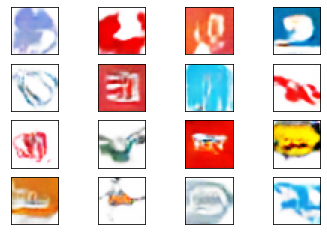

[i] (11:31:35) Epoch 281 [=]: Discriminator loss 0.4571917653083801 ( 0.859375 ) - Generator loss 1.2437434196472168
[i] (11:31:49) Epoch 282 [=]: Discriminator loss 0.4772449731826782 ( 0.890625 ) - Generator loss 1.21256422996521
[i] (11:32:03) Epoch 283 [=]: Discriminator loss 0.45812392234802246 ( 0.90625 ) - Generator loss 1.133414626121521
[i] (11:32:16) Epoch 284 [=]: Discriminator loss 0.5211291313171387 ( 0.8671875 ) - Generator loss 1.1866421699523926
[i] (11:32:29) Epoch 285 [=]: Discriminator loss 0.47710058093070984 ( 0.8671875 ) - Generator loss 1.2075088024139404
[i] (11:32:42) Epoch 286 [=]: Discriminator loss 0.4275846481323242 ( 0.90625 ) - Generator loss 1.2353367805480957
[i] (11:32:55) Epoch 287 [=]: Discriminator loss 0.5300237536430359 ( 0.8046875 ) - Generator loss 1.2430405616760254
[i] (11:33:09) Epoch 288 [=]: Discriminator loss 0.5071086883544922 ( 0.8359375 ) - Generator loss 1.1154148578643799
[i] (11:33:22) Epoch 289 [=]: Discriminator loss 0.448799669742

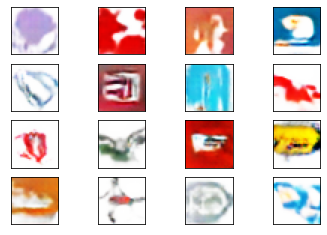

[i] (11:33:50) Epoch 291 [=]: Discriminator loss 0.44981440901756287 ( 0.8984375 ) - Generator loss 1.2080832719802856
[i] (11:34:03) Epoch 292 [=]: Discriminator loss 0.44780275225639343 ( 0.890625 ) - Generator loss 1.2043297290802002
[i] (11:34:16) Epoch 293 [=]: Discriminator loss 0.5221519470214844 ( 0.796875 ) - Generator loss 1.1375213861465454
[i] (11:34:30) Epoch 294 [=]: Discriminator loss 0.48884111642837524 ( 0.8515625 ) - Generator loss 1.1576449871063232
[i] (11:34:43) Epoch 295 [=]: Discriminator loss 0.4570278823375702 ( 0.8984375 ) - Generator loss 1.1610954999923706
[i] (11:34:56) Epoch 296 [=]: Discriminator loss 0.46423500776290894 ( 0.8984375 ) - Generator loss 1.22127103805542
[i] (11:35:09) Epoch 297 [=]: Discriminator loss 0.45567786693573 ( 0.90625 ) - Generator loss 1.191490650177002
[i] (11:35:22) Epoch 298 [=]: Discriminator loss 0.4793257713317871 ( 0.8515625 ) - Generator loss 1.2200849056243896
[i] (11:35:36) Epoch 299 [=]: Discriminator loss 0.4721045196

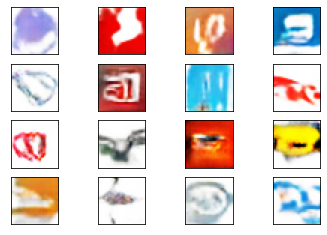

[i] (11:36:03) Epoch 301 [=]: Discriminator loss 0.44583839178085327 ( 0.890625 ) - Generator loss 1.2137993574142456
[i] (11:36:17) Epoch 302 [=]: Discriminator loss 0.4632702171802521 ( 0.8828125 ) - Generator loss 1.2104016542434692
[i] (11:36:30) Epoch 303 [=]: Discriminator loss 0.41564473509788513 ( 0.953125 ) - Generator loss 1.1780827045440674
[i] (11:36:43) Epoch 304 [=]: Discriminator loss 0.4808219075202942 ( 0.8984375 ) - Generator loss 1.2048356533050537
[i] (11:36:56) Epoch 305 [=]: Discriminator loss 0.47766631841659546 ( 0.890625 ) - Generator loss 1.2177473306655884
[i] (11:37:10) Epoch 306 [=]: Discriminator loss 0.46753427386283875 ( 0.875 ) - Generator loss 1.1712722778320312
[i] (11:37:23) Epoch 307 [=]: Discriminator loss 0.43764203786849976 ( 0.90625 ) - Generator loss 1.181144118309021
[i] (11:37:36) Epoch 308 [=]: Discriminator loss 0.46793267130851746 ( 0.8984375 ) - Generator loss 1.1819602251052856
[i] (11:37:49) Epoch 309 [=]: Discriminator loss 0.475525081

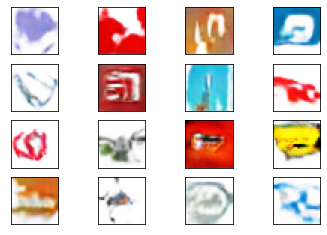

[i] (11:38:16) Epoch 311 [=]: Discriminator loss 0.5027824640274048 ( 0.828125 ) - Generator loss 1.190123438835144
[i] (11:38:30) Epoch 312 [=]: Discriminator loss 0.45962148904800415 ( 0.90625 ) - Generator loss 1.239304780960083
[i] (11:38:43) Epoch 313 [=]: Discriminator loss 0.44796299934387207 ( 0.8984375 ) - Generator loss 1.2310478687286377
[i] (11:38:56) Epoch 314 [=]: Discriminator loss 0.4672966003417969 ( 0.890625 ) - Generator loss 1.2746615409851074
[i] (11:39:09) Epoch 315 [=]: Discriminator loss 0.431380957365036 ( 0.9453125 ) - Generator loss 1.2087526321411133
[i] (11:39:22) Epoch 316 [=]: Discriminator loss 0.4570905268192291 ( 0.84375 ) - Generator loss 1.248575210571289
[i] (11:39:36) Epoch 317 [=]: Discriminator loss 0.4321140944957733 ( 0.890625 ) - Generator loss 1.30649995803833
[i] (11:39:49) Epoch 318 [=]: Discriminator loss 0.52055823802948 ( 0.84375 ) - Generator loss 1.276153564453125
[i] (11:40:02) Epoch 319 [=]: Discriminator loss 0.5240020751953125 ( 0.

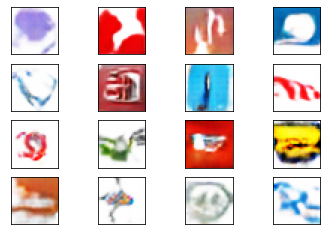

[i] (11:40:29) Epoch 321 [=]: Discriminator loss 0.39794662594795227 ( 0.9609375 ) - Generator loss 1.3271358013153076
[i] (11:40:42) Epoch 322 [=]: Discriminator loss 0.6114428639411926 ( 0.7109375 ) - Generator loss 1.3394032716751099
[i] (11:40:55) Epoch 323 [=]: Discriminator loss 0.3955720365047455 ( 0.953125 ) - Generator loss 1.279798984527588
[i] (11:41:09) Epoch 324 [=]: Discriminator loss 0.4201532304286957 ( 0.8984375 ) - Generator loss 1.24003005027771
[i] (11:41:22) Epoch 325 [=]: Discriminator loss 0.4839242994785309 ( 0.8203125 ) - Generator loss 1.2264976501464844
[i] (11:41:35) Epoch 326 [=]: Discriminator loss 0.4872996211051941 ( 0.8828125 ) - Generator loss 1.2619142532348633
[i] (11:41:48) Epoch 327 [=]: Discriminator loss 0.46231403946876526 ( 0.9140625 ) - Generator loss 1.317196249961853
[i] (11:42:01) Epoch 328 [=]: Discriminator loss 0.48718979954719543 ( 0.828125 ) - Generator loss 1.218724012374878
[i] (11:42:15) Epoch 329 [=]: Discriminator loss 0.459689050

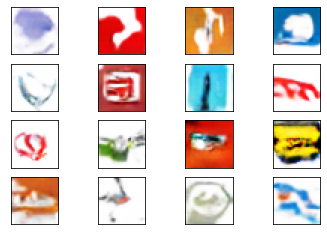

[i] (11:42:42) Epoch 331 [=]: Discriminator loss 0.414176344871521 ( 0.9296875 ) - Generator loss 1.2834041118621826
[i] (11:42:55) Epoch 332 [=]: Discriminator loss 0.4097211956977844 ( 0.9375 ) - Generator loss 1.3095030784606934
[i] (11:43:08) Epoch 333 [=]: Discriminator loss 0.47407981753349304 ( 0.8515625 ) - Generator loss 1.2588422298431396
[i] (11:43:21) Epoch 334 [=]: Discriminator loss 0.38160401582717896 ( 0.921875 ) - Generator loss 1.3122810125350952
[i] (11:43:34) Epoch 335 [=]: Discriminator loss 0.44580748677253723 ( 0.9140625 ) - Generator loss 1.3104655742645264
[i] (11:43:48) Epoch 336 [=]: Discriminator loss 0.46420818567276 ( 0.8671875 ) - Generator loss 1.2841190099716187
[i] (11:44:01) Epoch 337 [=]: Discriminator loss 0.42488664388656616 ( 0.921875 ) - Generator loss 1.2867621183395386
[i] (11:44:14) Epoch 338 [=]: Discriminator loss 0.6658608913421631 ( 0.7265625 ) - Generator loss 1.296714186668396
[i] (11:44:27) Epoch 339 [=]: Discriminator loss 0.4292741119

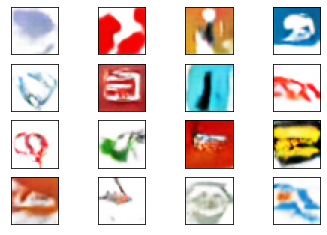

[i] (11:44:54) Epoch 341 [=]: Discriminator loss 0.43952932953834534 ( 0.90625 ) - Generator loss 1.19081711769104
[i] (11:45:07) Epoch 342 [=]: Discriminator loss 0.45167896151542664 ( 0.875 ) - Generator loss 1.2704472541809082
[i] (11:45:21) Epoch 343 [=]: Discriminator loss 0.43869104981422424 ( 0.96875 ) - Generator loss 1.2491865158081055
[i] (11:45:34) Epoch 344 [=]: Discriminator loss 0.40966153144836426 ( 0.9453125 ) - Generator loss 1.2849562168121338
[i] (11:45:47) Epoch 345 [=]: Discriminator loss 0.43533530831336975 ( 0.9609375 ) - Generator loss 1.2452316284179688
[i] (11:46:00) Epoch 346 [=]: Discriminator loss 0.45790743827819824 ( 0.8671875 ) - Generator loss 1.2664353847503662
[i] (11:46:13) Epoch 347 [=]: Discriminator loss 0.43698084354400635 ( 0.90625 ) - Generator loss 1.2953951358795166
[i] (11:46:26) Epoch 348 [=]: Discriminator loss 0.4779432713985443 ( 0.8359375 ) - Generator loss 1.192338466644287
[i] (11:46:39) Epoch 349 [=]: Discriminator loss 0.42159605026

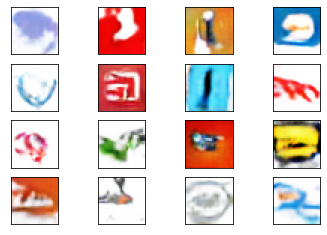

In [24]:
#keep track of loss and accuracy separately for true and fake images
history = {}
history['G_loss'] = []
history['D_loss_true'] = []
history['D_loss_fake'] = []

accuracy = {}
accuracy['Acc_true'] = []
accuracy['Acc_fake'] = []

# for each epoch
for epoch in range(NUM_EPOCHS):
  batchesPerEpoch = int(training_size / BATCH_SIZE)
  q = 1
  now = datetime.now()
  current_time = now.strftime("%H:%M:%S")
  print(f"[i] ({current_time}) Epoch {epoch} [", end ="")

  # for each batch
  for b in (range(1, batchesPerEpoch+1)):
    if ((b*10/batchesPerEpoch) % q ) == 0:
      q=q+1
      print("=", end ="")

    # Training the discriminator to differentiate between true and fake images
    trueImages, _ = next(train)

    # One sided label smoothing reduces overconfidence in true images and stabilizes training a bit
    y = 0.9*np.ones((trueImages.shape[0]))
    discLoss, discAcc = disc.train_on_batch(trueImages, y)
    
    history['D_loss_true'].append(discLoss)    

    # Warning: accuracy will not be calculated if label smoothing is used 
    accuracy['Acc_true'].append(discAcc)
    
    # Generating some fake samples
    noise =  generate_latent_points(NUM_Z, BATCH_SIZE)
    genImages=gen.predict(noise)
    y = np.zeros((BATCH_SIZE))

    discLoss, discAcc = disc.train_on_batch(genImages, y)
    history['D_loss_fake'].append(discLoss)          
    accuracy['Acc_fake'].append(discAcc)

    # Training the generator
    noise =  generate_latent_points(NUM_Z, BATCH_SIZE)

    # NOTE: Some authors suggest randomly flipping some labels to introduce random variations
    fake_labels = [1] * BATCH_SIZE
    fake_labels = np.reshape(fake_labels, (-1,))
    ganLoss = gan.train_on_batch(noise, fake_labels)
    
    history['G_loss'].append(ganLoss)

  print("]:", end=" ")
  print(f"Discriminator loss {str(discLoss)} ( {str(discAcc)} ) - Generator loss {str(ganLoss)}")

  images = gen.predict(benchmarkNoise)

  # Visualizing the output and saving it
  if (epoch % 10) == 0:
    store_figures(images, 4, directory_models, epoch)
    plot_figures(images, 4)
    gan.save(os.path.join(directory_models, "logocGAN_" + str(epoch)+".h5"))


# Plotting metrics

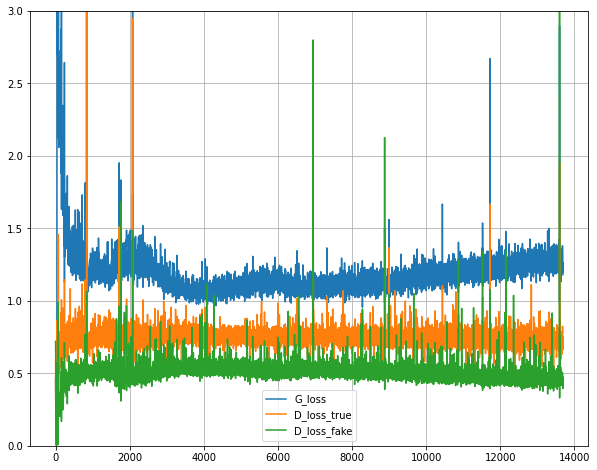

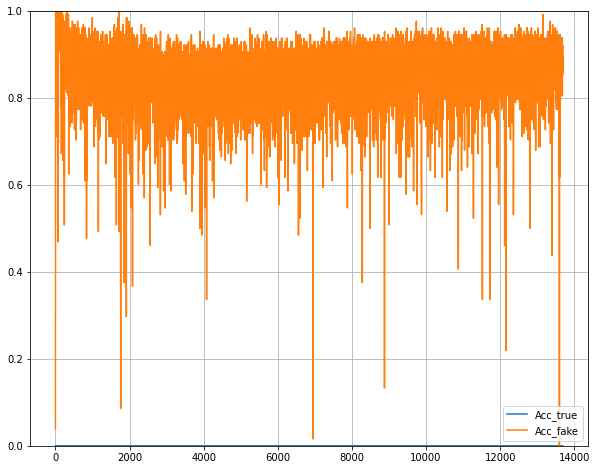

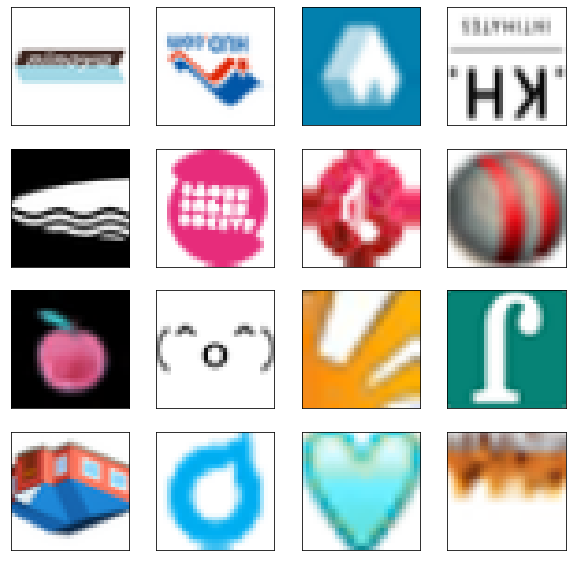

In [25]:
plot_losses(history, 3)
plot_losses(accuracy, 1)
plot_figures(trueImages, 4, figsize=(10, 10))

In [26]:
# Reloading the model at the selecte epoch

epoch =  260
leaky = tf.keras.layers.LeakyReLU(0.2)
tf.keras.utils.get_custom_objects().update({'LeakyReLU': leaky})
gan = tf.keras.models.load_model(os.path.join(directory_models, "logocGAN_" + str(epoch)+".h5"))

gen = gan.layers[1]

gen.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 2048)         206848      ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048)        8192        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 reshape (Reshape)              (None, 2, 2, 512)    0           ['batch_normalization[0][0]']

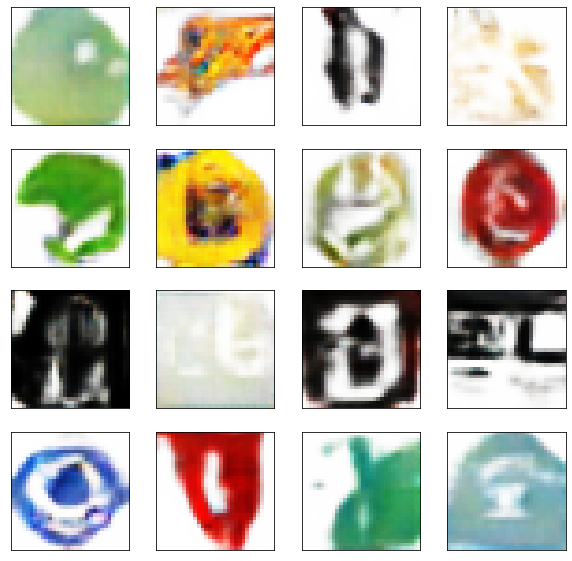

In [27]:
noisevector = generate_latent_points(NUM_Z, BATCH_SIZE)

genImages = gen.predict(noisevector)    
plot_figures(genImages,4, figsize=(10, 10))